[GDCV08] 도로 영역을 찾자! - 세그멘테이션 모델 만들기

<<목차>>

1) KITTI 데이터셋 수집과 구축

2) U-Net++ 모델의 구현

3) U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

4) 루브릭

5) 회고

In [10]:
# 필요한 라이브러리를 로드합니다. 
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1) KITTI 데이터셋 수집과 구축

In [16]:
DATA_DIR = '/home/june/Github/GDCV/data/gd08'

TRAIN_PATH = os.path.join(DATA_DIR, 'training')
TEST_PATH = os.path.join(DATA_DIR, 'testing')

In [17]:
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

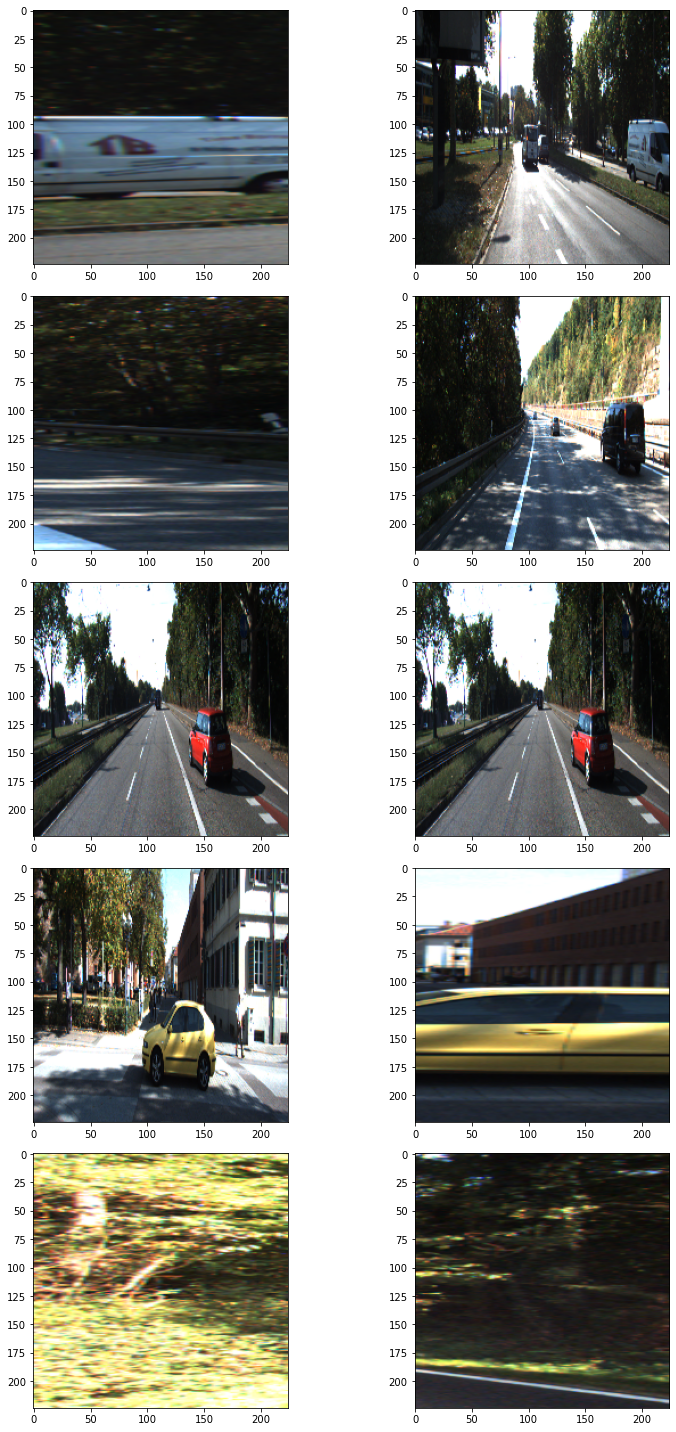

In [18]:
augmentation = build_augmentation()

input_images = glob(os.path.join(TRAIN_PATH, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.tight_layout()
plt.show()

In [19]:
class KittiGenerator(tf.keras.utils.Sequence):

  def __init__(self, 
              train_path,
              batch_size=16,
              img_size=(224, 224, 3),
              output_size=(224, 224),
              is_train=True,
              augmentation=None):
    
    self.TRAIN_PATH = train_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.TRAIN_PATH = train_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.TRAIN_PATH, "image_2", "*.png"))
    label_images = glob(os.path.join(self.TRAIN_PATH, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                          index*self.batch_size:
                          (index + 1)*self.batch_size
                          ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes


In [21]:
BATCH_SIZE = 4

In [22]:
# augmentation = build_augmentation()
train_preproc = build_augmentation(is_train=True)
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE,
    augmentation=train_preproc,
    is_train=True
)

test_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE, 
    augmentation=test_preproc,
    is_train=False
)

In [24]:
EPOCHS = 20

In [25]:
def conv_block(dim, x, concat_list=[], to_up_concat=False, to_pool=False):
    if to_up_concat:
        x = Conv2DTranspose(dim, 2, activation='elu', strides=(2,2), kernel_initializer='he_normal')(x)  # Up Sampling
        concat_list.append(x)
        x = concatenate(concat_list, axis = 3)  # Skip Connection

    x = Conv2D(dim, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    x = Conv2D(dim, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)

    if to_pool:
        x = MaxPooling2D(pool_size=(2, 2))(x)  # Down Sampling

    return x


def get_model_outputs(x):
    x = Conv2D(2, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)     
    x = Conv2D(1, 1, activation='sigmoid')(x)

    return x


In [26]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    # Contracting Path (Left)
    conv1 = conv_block(filter_list[0], inputs)
    conv2 = conv_block(filter_list[1], conv1, to_pool=True)
    conv3 = conv_block(filter_list[2], conv2, to_pool=True)
    conv4 = conv_block(filter_list[3], conv3, to_pool=True)

    conv5 = conv_block(filter_list[4], conv4, to_pool=True)  # (Middle)

    # Expanding Path (Right)
    conv6 = conv_block(filter_list[3], conv5, [conv4], to_up_concat=True)
    conv7 = conv_block(filter_list[2], conv6, [conv3], to_up_concat=True)
    conv8 = conv_block(filter_list[1], conv7, [conv2], to_up_concat=True)
    conv9 = conv_block(filter_list[0], conv8, [conv1], to_up_concat=True)

    outputs = get_model_outputs(conv9)

    # U-Net 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model


In [27]:
unet = build_unet()

2022-12-12 15:49:27.178116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 15:49:27.179069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 15:49:27.179341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 15:49:27.179526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [28]:
unet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [37]:
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/20


2022-12-12 17:17:47.195823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-12-12 17:17:49.589320: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


43/43 [==============================] - 30s 281ms/step - loss: 0.2316 - accuracy: 0.8987 - val_loss: 0.4572 - val_accuracy: 0.8245
Epoch 2/20
43/43 [==============================] - 12s 273ms/step - loss: 0.0921 - accuracy: 0.9631 - val_loss: 0.2353 - val_accuracy: 0.9326
Epoch 3/20
43/43 [==============================] - 12s 274ms/step - loss: 0.0822 - accuracy: 0.9666 - val_loss: 0.1485 - val_accuracy: 0.9417
Epoch 4/20
43/43 [==============================] - 12s 274ms/step - loss: 0.0554 - accuracy: 0.9803 - val_loss: 0.2355 - val_accuracy: 0.9400
Epoch 5/20
43/43 [==============================] - 12s 274ms/step - loss: 0.0616 - accuracy: 0.9754 - val_loss: 0.2224 - val_accuracy: 0.9436
Epoch 6/20
43/43 [==============================] - 12s 274ms/step - loss: 0.0733 - accuracy: 0.9705 - val_loss: 0.3081 - val_accuracy: 0.9380
Epoch 7/20
43/43 [==============================] - 12s 274ms/step - loss: 0.0731 - accuracy: 0.9683 - val_loss: 0.2289 - val_accuracy: 0.9612
Epoch 8/20

In [38]:
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_DIR, f'{model_name}_Result.png'))  # 저장
    plt.show()

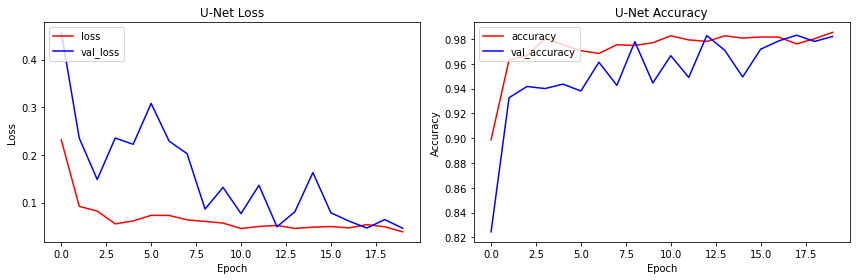

In [39]:
draw_unet_history(unet_history, 'U-Net')

In [40]:
UNET_PATH = os.path.join(DATA_DIR, 'seg_model_unet.h5')


In [41]:
unet.save(UNET_PATH)  # 학습한 모델을 저장해 주세요.


2) U-Net++ 모델의 구현

In [43]:
def build_unet_pp(input_shape=(224, 224, 3), deep_supervision=True):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    x_00 = conv_block(filter_list[0], inputs)
    x_10 = conv_block(filter_list[1], x_00, to_pool=True)
    x_20 = conv_block(filter_list[2], x_10, to_pool=True)
    x_30 = conv_block(filter_list[3], x_20, to_pool=True)
    x_40 = conv_block(filter_list[4], x_30, to_pool=True)

    x_01 = conv_block(filter_list[0], x_10, [x_00], to_up_concat=True)
    x_11 = conv_block(filter_list[1], x_20, [x_10], to_up_concat=True)
    x_21 = conv_block(filter_list[2], x_30, [x_20], to_up_concat=True)

    x_02 = conv_block(filter_list[0], x_11, [x_00,x_01], to_up_concat=True)
    x_12 = conv_block(filter_list[1], x_21, [x_10,x_11], to_up_concat=True)

    x_03 = conv_block(filter_list[0], x_12, [x_00,x_01,x_02], to_up_concat=True)

    x_31 = conv_block(filter_list[3], x_40, [x_30], to_up_concat=True)
    x_22 = conv_block(filter_list[2], x_31, [x_20], to_up_concat=True)
    x_13 = conv_block(filter_list[1], x_22, [x_10], to_up_concat=True)
    x_04 = conv_block(filter_list[0], x_13, [x_00,x_01,x_02,x_03], to_up_concat=True)

    if deep_supervision:
        x_01_outputs = get_model_outputs(x_01)
        x_02_outputs = get_model_outputs(x_02)
        x_03_outputs = get_model_outputs(x_03)
        x_04_outputs = get_model_outputs(x_04)

        outputs_list = [x_01_outputs, x_02_outputs, x_03_outputs, x_04_outputs]
        outputs = tf.keras.layers.Average()(outputs_list)  # 레이어 모든 값 평균 계산 => sum(outputs_list)/len(outputs_list) 과 결과 같음
    else:
        outputs = get_model_outputs(x_04)

    # U-Net++ 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model


In [44]:
unet_pp = build_unet_pp()

In [45]:
unet_pp.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 224, 224, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [46]:
from keras import backend as K

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [48]:
unet_pp.compile(
    optimizer = Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

unet_pp_history = unet_pp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/20


2022-12-12 17:24:59.600177: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 49.00MiB (rounded to 51380224)requested by op model_1/batch_normalization_39/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-12 17:24:59.600239: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-12-12 17:24:59.600248: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 405, Chunks in use: 405. 101.2KiB allocated for chunks. 101.2KiB in use in bin. 64.6KiB client-requested in use in bin.
2022-12-12 17:24:59.600251: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 211, Chunks in use: 210. 106.2KiB allocated for chunks. 105.8KiB in use in bin. 105.0KiB client-reques

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/batch_normalization_39/FusedBatchNormV3' defined at (most recent call last):
    File "/home/june/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/june/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/june/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/june/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/june/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/june/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/june/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/june/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/june/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/june/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/june/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/june/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/june/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_24289/3412024157.py", line 7, in <cell line: 7>
      unet_pp_history = unet_pp.fit(
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/june/anaconda3/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/batch_normalization_39/FusedBatchNormV3'
OOM when allocating tensor with shape[4,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/batch_normalization_39/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_28454]

cator.cc:1089] InUse at 7fe5d32ef500 of size 1179648 next 671
2022-12-12 17:25:09.611149: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fe5d340f500 of size 512 next 672
2022-12-12 17:25:09.611152: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fe5d340f700 of size 589824 next 673
2022-12-12 17:25:09.611154: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fe5d349f700 of size 256 next 674
2022-12-12 17:25:09.611156: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fe5d349f800 of size 512 next 675
2022-12-12 17:25:09.611159: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fe5d349fa00 of size 512 next 676
2022-12-12 17:25:09.611161: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fe5d349fc00 of size 256 next 677
2022-12-12 17:25:09.611163: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fe5d349fd00 of size 256 next 678
2022-12-12 17:25:09.611165: I tensorflow/core/

09.611988: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 1 Chunks of size 2621440 totalling 2.50MiB
2022-12-12 17:25:09.611991: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 1 Chunks of size 2736128 totalling 2.61MiB
2022-12-12 17:25:09.611993: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 1 Chunks of size 3211264 totalling 3.06MiB
2022-12-12 17:25:09.611996: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 18 Chunks of size 4718592 totalling 81.00MiB
2022-12-12 17:25:09.611999: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 1 Chunks of size 5767168 totalling 5.50MiB
2022-12-12 17:25:09.612001: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 4 Chunks of size 6422528 totalling 24.50MiB
2022-12-12 17:25:09.612004: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 1 Chunks of size 7077888 totalling 6.75MiB
2022-12-12 17:25:09.612006: I tensorflow/core/common_runtime/bfc_allocator.cc:1097] 7 Chunks of size 8388608 totalling 56.00M

In [ ]:
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Dice Coef 시각화
    plt.subplot(122)
    plt.plot(history.history['dice_coef'], 'r')
    plt.plot(history.history['val_dice_coef'], 'b')
    plt.title(f'{model_name} Dice Coef')
    plt.ylabel(f'{model_name} Dice Coef')
    plt.xlabel('Epoch')
    plt.legend(['dice_coef', 'val_dice_coef'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_DIR, f'{model_name}_Result.png'))  # 저장
    plt.show()

In [ ]:
draw_unet_history(unet_pp_history, model_name='U-Net++')
